# Black-hole binary formation channels with gaussian mixtures.

Many problems in astrophysics give rise to data with multiple modes. This is typically because different processes physical processes contribute to the observed dataset. 

For instance, one of the most outstanding question in gravitational-wave astrophysics is the formation channel of binary black holes. Leading scenarions include the evolution of isolated binaries in the galactic field and the dynamica assembly of sources in dense environments like globular clusters.https://classic.sdss.org/includes/sideimages/sdss_pie2


Right now, state-of-the-art analyses seems to say that many channels are all at play. This is a plot by [Zevin et al (2020)](https://arxiv.org/abs/2011.10057)


<img src="../images/formation_channels.png" width="700">

where they consider 5 possibilities for the formation of black hole binaries: common envelop (CE), chemically omogenous stars (CHE), globular clusters (GC), nuclear star clusters (NSC) and stable mass transfer (SMT). 

If you want to know more about LIGO-driven astrophysics and black hole binaries formation channels, these are some recent reviews: [Mandel and Farmer (2021)](https://arxiv.org/abs/1806.05820), [Mapelli (2021)](https://arxiv.org/abs/2106.00699), [Gerosa and Fishbach (2021)](https://arxiv.org/abs/2105.03439).



Some events form in different astrophysical environments than others. **You want to figure out how many of formation channels are at play.**


The strategy here is to fit a Gaussian Mixture model: that is, my model is a sum of $N$ gaussians each with mean $\mu_j$ and standard deviation $\sigma_j$ and weight $\alpha_j$:

$p(x_i|\theta) = \sum_{j=1}^N \alpha_j \mathcal{N}(\mu_j,\sigma_j) $

This depends on $3N-1$ parameters (not $3N$ because the sum of the $\alpha_j$ must be unity to ensure that this is a probability.

#### Tasks

1) Load this file (`np.load`) and complete a quick exploration of the data. How many modes do you think you see?

2) Take some time to explore `sklearn.mixture.GaussianMixture`. Check the documentation, some examples, the help menu, etc. You first need to define the model (instance of a class), and then train it on the data using the `fit` method (the data provided are already in the right numpy format!). This will output the trained model, which has various attributes.

*Note*. We'll do a more formal introduction to scikit-learn in one of the next lectures. This is meant to be a formative example on how you might find yourself dealing with a library you've never seen before. This happens *all the time* in scientific research!

3) Complete the fit 10 times with $N=1,...,10$ Gaussians. 

Note: `sklearn` by default will use the so-called [Expectation-Maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm), which is one of the many great things in data science we don't have time to study in detail.

4) For each of this fits, compute the AIC (easy! It's a attribute of the trained model!). Plot $N$ vs AIC: which model is preferred?

5) Plot the preferred solution on top of the input data. You should get a very nice fit!

6) Understand (i.e. plot) which Gaussian mode corresponds to which part of the input dataset. 

*Hint:* Useful methods here are `score_samples` and `predict_proba`: you'll need them both. Try to understand what they do and how you can put them together.


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import random

from IPython.display import display, HTML

In [2]:
data = np.load("/home/robertoinfurna/Desktop/astrostatistics_bicocca_2024/solutions/formationchannels.npy")

In [32]:
print(data.shape)

(2950, 1)


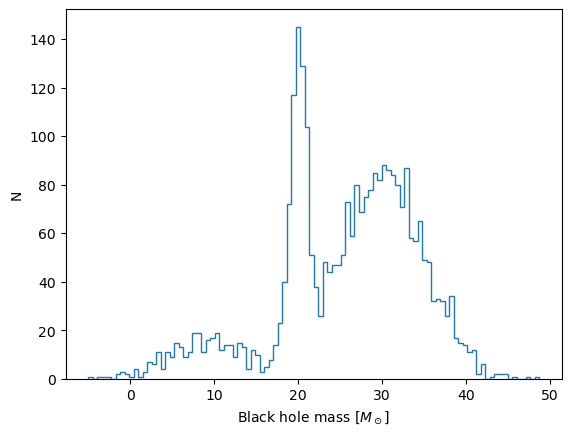

In [5]:
plt.hist(data,bins=100,histtype='step');
plt.xlabel("Black hole mass $[M_\odot]$")
plt.ylabel("N")
plt.show()

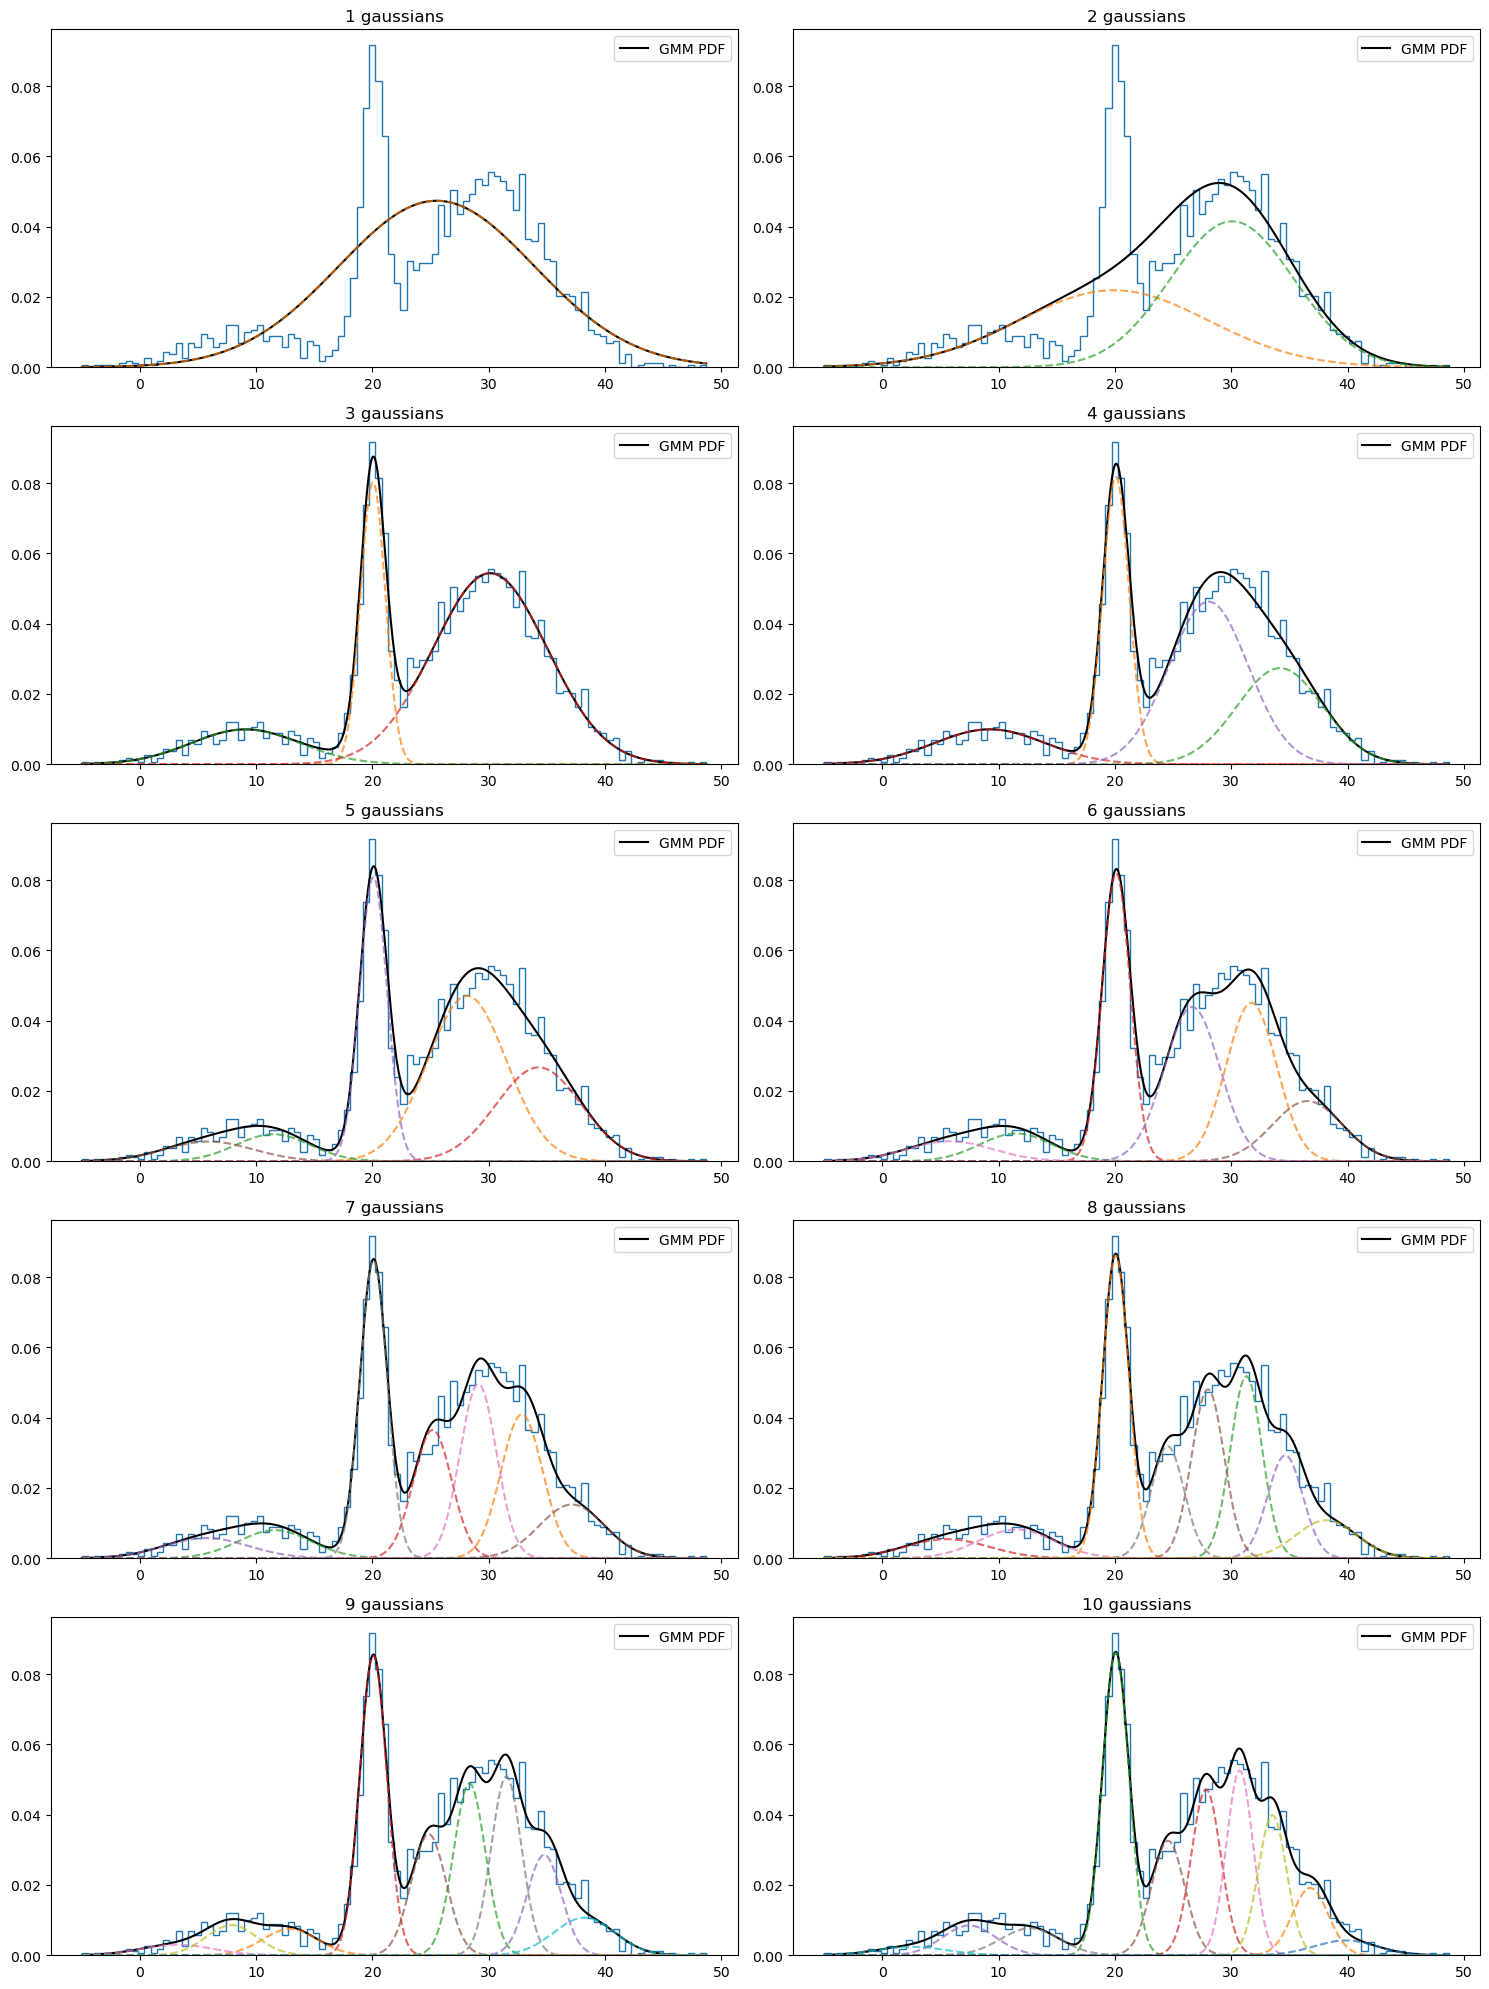

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# fit gaussian mixtures models with 1 to 10 components
gauss_mixture_models = []
for N in range(1,11):
    gauss_mixture_models.append(GaussianMixture(N).fit(data))

# Prepare grid for plotting
x = np.linspace(np.min(data), np.max(data), 1000).reshape(-1, 1)

fig, axs = plt.subplots(5, 2, figsize=(15, 20))
axs = axs.ravel()

for i, gmm in enumerate(gauss_mixture_models):
    ax = axs[i]

    ax.hist(data,bins=100,histtype='step',density=True);
    
    # Overall GMM PDF
    logprob = gmm.score_samples(x)
    pdf = np.exp(logprob)
    ax.plot(x, pdf, c='black', label='GMM PDF')

    # Individual component PDFs
    for w, mu, cov in zip(gmm.weights_, gmm.means_, gmm.covariances_):
        std = np.sqrt(cov).flatten()  # For 1D
        component_pdf = w * (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mu)**2) / cov)
        ax.plot(x, component_pdf.flatten(), linestyle='--', alpha=0.7)

    ax.set_title(f'{i+1} gaussians')
    ax.legend()

plt.tight_layout()
plt.show()



### Which of the gaussian mixture models better describes the data? How many gaussians do we actually need?

Popular general-purpose tool for model comparison is the **Akaike Information Criterion** (AIC):

$$ \mathrm{AIC}_M \equiv -2\ln[L^0(M)] + 2k + \frac{2k(k+1)}{N-k-1}, $$

where $k$ is the number of model parameters and $N$ is the number of data points.

- For a Gaussian distribution, the first term is equal to $\chi^2$.
- **The model with lowest AIC is the most favored.**
- If all models are equally successful at fitting the data (equal $L^0$ values) then the second and third terms penalize model complexity such that the model with fewest free parameters wins.


Another quick and dirty estimate is the **Bayesian Information Criterion (BIC)**:

$$BIC=k\ln⁡(n)−2\ln⁡(L^)$$

where $n$ is the number of data points, $k$ the number of model free parameters, and $L^0(M)$ it the likelihood. 
- Stronger penalty for complexity than AIC
- Lower BIC = better


In [38]:
AIC = [m.aic(data) for m in gauss_mixture_models]
for i in range(10):
    print(i+1, AIC[i])
print('The AIC is minimized for N=', range(1,11)[np.argmin(AIC)])

1 20945.9726085902
2 20754.077242280502
3 20083.175884272056
4 20101.612849149024
5 20112.512954370923
6 20123.197559288536
7 20130.49377477095
8 20135.595153839386
9 20138.74771268232
10 20141.760459656572
The AIC is minimized for N= 3


In [39]:
# And BIC ?

BIC = [m.bic(data) for m in gauss_mixture_models]
for i in range(10):
    print(i+1, BIC[i])
print('The BIC is minimized for N=', range(1,11)[np.argmin(BIC)])

1 20957.95172948887
2 20784.02504452717
3 20131.092367866728
4 20167.498014091696
5 20196.366800661595
6 20225.020086927212
7 20250.284983757625
8 20273.355044174066
9 20294.476284365002
10 20315.457712687254
The BIC is minimized for N= 3


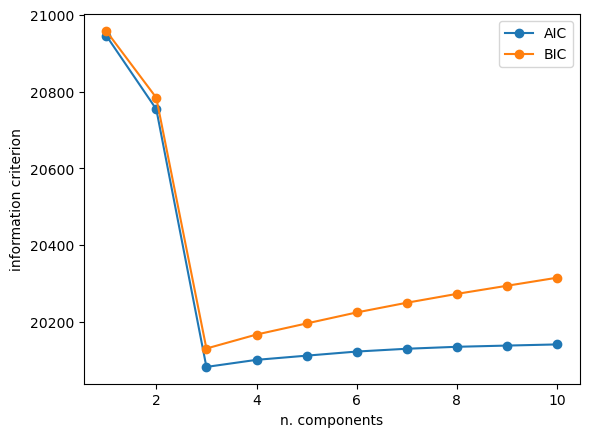

In [41]:

plt.plot(range(1,11), AIC,  marker='o', linestyle = '-', label='AIC')
plt.plot(range(1,11), BIC,  marker='o', linestyle= '-', label='BIC')

plt.legend()
plt.xlabel('n. components')
plt.ylabel('information criterion');


In [49]:
# Responsabilities
# gives the probability for each point of dataset of coming from one particular gaussian of the gaussian mixture
responsibilities = gauss_mixture_models[9].predict_proba(data.reshape(-1, 1))
print(responsibilities)

[[2.45263543e-035 6.40623088e-001 2.47026661e-015 ... 5.70173578e-039
  3.97089280e-006 3.70207410e-016]
 [5.04844500e-087 2.09785368e-033 3.29238229e-065 ... 9.34398092e-111
  1.53471851e-001 2.60350032e-035]
 [1.00207291e-084 1.78475328e-031 8.91791711e-063 ... 1.83554432e-107
  1.19919098e-001 1.66732206e-034]
 ...
 [1.41544519e-001 9.10424066e-035 2.10563707e-006 ... 8.35450361e-001
  2.87812449e-026 1.38960592e-002]
 [4.50993021e-005 4.08738846e-018 1.28929648e-001 ... 1.95067758e-002
  1.31717520e-020 1.39289281e-004]
 [9.81118068e-012 3.78205234e-006 4.25581957e-001 ... 4.30853043e-009
  4.53781382e-015 2.03526291e-007]]


### Class labels or "responsibilities"

Class labels are a very interesting by products of a mixture analysis.

What is the probability that a given gravitational-wave event comes from a given channel? This is called "responsiblity" (i.e. which mode is most likely to be responsible for that piece of data). 

$p(j|x_i) = \frac{a_j \mathcal{N(\mu_j,\sigma_j)}}{\sum_{j=1}^N \alpha_j \mathcal{N}(\mu_j,\sigma_j)}$


#### This result comes from Bayes' rule

$p(j|x_i)p(x_i) = p(x_i|j)p(j)$

- $p(x_i|j) = \mathcal{N(\mu_j,\sigma_j)(x_i)}$ is the likelihood (of 1 element dataset)
- $p(j) = a_j$ is the prior. How much a formation channel is a-priori most probable than another (i.e. number of globular clusters vs number of nuclear star clusters)
- $p(x_i) = \sum_j N(\mu_j,\sigma_j)(x_i)$ is the evidence